In [1]:
import librosa.display
import numpy as np
import os
import torch 
import torch.utils.data
import torch.optim as optim
import os
import librosa
import glob 
import matplotlib.pyplot as plt
from pyAudioAnalysis import audioBasicIO
import sys
stdout = sys.stdout
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
# emotions
emotion= ["neutral","calm","happy", "sad","angry","fearful", "disgust","surprised"]

A
A
A


In [2]:
def sample_zero_mean(x):
    
    mean=((x.sum(axis=2)) / x.shape[2])
    
    zero_mean = x - mean.reshape(mean.shape[0],mean.shape[1],1)
    return zero_mean
    pass

def feature_zero_mean(x):
    
    mean=((x.sum(axis=1)) / x.shape[1])
    
    zero_mean = x - mean.reshape(mean.shape[0],1)
    return zero_mean
    pass

def data_zero_mean(x):
    
    mean=((x.sum(axis=0)) / x.shape[0])
    
    zero_mean = x - mean.reshape(1,mean.shape[0])
    return zero_mean
    pass

In [3]:
data_list = []
dir_n = "data/test_data/happy-sad-neutral/t2/"
files = np.array(os.listdir("data/test_data/happy-sad-neutral/t2/"))
from pydub import AudioSegment

for i,name in enumerate(files):
    data_list.append(name)
    sound = AudioSegment.from_wav(str(dir_n)+"/"+str(name))
    sound = sound.set_channels(1)
    sound.export(str(dir_n)+"/"+str(name), format="wav")
file_names = np.array(data_list).reshape(-1)


In [4]:
def get_items(batch):
    label= []
    data_list = []
    
    for i in batch:
#         y, sr = librosa.load("data/test_data/happy-sad-neutral/t2/"+file_names[i],duration=3,offset=1.0)
#         y = librosa.util.normalize(y)
#         S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
#         log_S = librosa.power_to_db(S, ref=np.max)
        temp_label = float(file_names[i][7])
        
#         print (float(file_names[i][7]))
        if temp_label in [1]:
            label.append(float(0))
        elif temp_label in [3]:
            label.append(float(1))
        else:
            label.append(float(2))
#         mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#         tonnetz = librosa.effects.harmonic(y=y )
#         tonnetz = librosa.feature.tonnetz(y=tonnetz, sr=sr)
#         rms = librosa.feature.rmse(y=y)
#         chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
# #         feature_zero_mean(data_zero_mean(mfccs))
#         abc = feature_zero_mean(data_zero_mean(np.concatenate((mfccs,
#                               S,
#                               tonnetz,
#                               rms,
#                               chroma_cqt
#                              ),axis=0)))
#         print (abc.shape)
        [Fs, x] = audioBasicIO.readAudioFile("data/test_data/happy-sad-neutral/t2/"+file_names[i]);
        F = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.050*Fs, 0.025*Fs);
        abc = feature_zero_mean(data_zero_mean(F))
        abc = np.transpose(abc,(1,0))
        data_list.append(abc)
        import sys
        reload(sys)
        sys.setdefaultencoding('utf-8')
        sys.stdout = stdout

#         abc = np.transpose(abc,(1,0))
#         data_list.append(abc)
    return np.array(data_list),np.array([label]).reshape(-1,1)

In [5]:
_use_shared_memory = False
def collate (batch):
    train ,in_label = get_items(batch)
    
#     print (in_label.shape)
    N=train.shape[0]
    max_seq = train[0].shape[0]
    
    seq_lens=torch.IntTensor(N)
    
    for i in np.arange(N):
        if(max_seq<train[i].shape[0]):
            max_seq=train[i].shape[0]
        seq_lens[i]=train[i].shape[0]
#         print('Train ',train[i].shape)
    L=max_seq
    D=train[i].shape[1]
    if _use_shared_memory:
        tr = torch.FloatStorage._new_shared(max_seq*train.shape[0]*D).new().zero_()
    else:
        tr = torch.FloatTensor(N,L,D).zero_()
        inp_lbl = torch.FloatTensor(N).zero_()
    for i in np.arange(N):
        tr[i, 0:train[i].shape[0] , : ]=to_tensor(train[i])
        #inp_lbl[i] = to_tensor(in_label[i].reshape(-1,1)) 
    sort_len,ind = torch.sort(seq_lens,descending=True)
    tr2=  tr[ind,:,:]
    inp_lbl=to_tensor(in_label)
    inp_lbl=inp_lbl[ind]
    return tr2,sort_len,inp_lbl

def to_tensor(numpy_array):
    return torch.from_numpy(numpy_array).float()


def to_variable(tensor):
    if torch.cuda.is_available():
        #print ("making it cuda")
        tensor = tensor.cuda()
    return torch.autograd.Variable(tensor,requires_grad=True)

def to_variable2(tensor):
    if torch.cuda.is_available():
        #print ("making it cuda")
        tensor = tensor.cuda()
    return torch.autograd.Variable(tensor)


In [6]:
from torch.utils.data import DataLoader, Dataset
data_loader = DataLoader(np.arange(len(file_names)), shuffle=False,
                         batch_size=32, collate_fn=collate)

for i in data_loader:
    print ('A')

In [7]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class Conv1D(nn.Module):
    def __init__(self):
        super(Conv1D, self).__init__()
        self.output_size = 46
        self.n_layers = 2
        self.c1 = nn.Conv1d(34,128,3,padding=1)
        self.c3 = nn.Conv1d(128,32,3,padding=1)
        self.batchNorm = nn.BatchNorm1d(32)
        self.linear = nn.Linear(32,3)
        #print ("relu added")
    def forward(self, inputs,lens):
        mask = to_variable2(torch.zeros(inputs.shape[0],inputs.shape[1]))
        for i in np.arange(len(lens)):
            mask[i,0:lens[i]]=1
            
        inputs = torch.transpose(inputs,1,2)
        out = F.leaky_relu(self.c1(inputs))
        out = out * mask.unsqueeze(1) 
        out =  F.leaky_relu(self.c3(out))
        out = out * mask.unsqueeze(1) 
        out = F.dropout((F.leaky_relu(out)),0.3)
        out = self.batchNorm(out)
        
        out = torch.mean(out,2)
        print(out.shape)
        out = self.linear(out)
        
        return out

In [8]:
net = Conv1D()
net.load_state_dict(torch.load('models/model.pt'))

In [22]:
from sklearn.metrics import confusion_matrix
criterion = nn.CrossEntropyLoss()
net.eval()
train_loss = 0
correct = 0
total = 0
train_loss = 0
correct = 0
total = 0
p=[]
l=[]
for  batch_idx,(inputs, seqlen,targets) in enumerate(data_loader):
#     if batch_idx == len(data_loader)-1:
#         continue
    inputs, targets = to_variable(inputs), to_variable2(targets)
    outputs = net(inputs,seqlen.numpy())
    outputs = F.softmax(outputs)
    loss = criterion(outputs, targets.long().view(-1))
    train_loss += loss.data[0]
    _, predicted = torch.max(outputs.data, 1)
#     print (np.round(F.softmax(outputs).data.numpy(),2))
    predicted = predicted.view(-1,1)
    if (batch_idx==0):
        probs = outputs.data.numpy()
        p=predicted.numpy()
        l=targets.data.numpy()
    else: 
        probs = np.vstack((probs,outputs.data.numpy()))
        p=np.vstack((p,predicted.numpy()))
        l=np.vstack((l,targets.data.numpy()))
    total += targets.size(0)
    correct += predicted.eq(targets.long().data).cpu().sum()
    print(batch_idx, len(data_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    

torch.Size([32, 32])
(0, 3, 'Loss: 0.712 | Acc: 84.375% (27/32)')
torch.Size([32, 32])
(1, 3, 'Loss: 0.726 | Acc: 85.938% (55/64)')
torch.Size([21, 32])
(2, 3, 'Loss: 0.712 | Acc: 88.235% (75/85)')


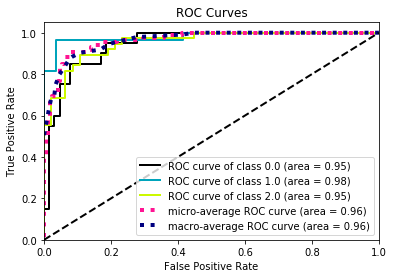

In [23]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = l# ground truth labels
y_probas = probs# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix
print (confusion_matrix(l,p)*3)
sum(sum(confusion_matrix(l,p))*3)

[[ 45   0  15]
 [  3  78   0]
 [  6   6 102]]


255

In [14]:
print (probs.shape)

(85, 3)


In [12]:
!sudo pip install scikit-plot

The directory '/home/nyismaw_c4gcp/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/nyismaw_c4gcp/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


In [78]:
print (l.reshape(-1))
l = l.reshape(-1)
multi_label_one_hat = np.zeros((85,3)).astype(int)
print (l.astype(int))
for i in range(len(l)):
    
    multi_label_one_hat[i,l[i].astype(int)] = 1
# print (multi_label_one_hat)

[2. 2. 0. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 1. 0. 0. 2. 2. 2. 0. 0. 0. 0.
 1. 1. 2. 2. 0. 0. 0. 0. 1. 1. 2. 1. 0. 2. 1. 2. 2. 1. 0. 2. 2. 2. 2. 2.
 0. 0. 1. 0. 2. 1. 2. 2. 0. 2. 2. 1. 0. 1. 0. 2. 2. 2. 1. 2. 2. 2. 1. 2.
 1. 2. 2. 1. 2. 1. 0. 2. 1. 1. 2. 1. 1.]
[2 2 0 2 2 2 2 1 1 1 1 1 1 2 1 0 0 2 2 2 0 0 0 0 1 1 2 2 0 0 0 0 1 1 2 1 0
 2 1 2 2 1 0 2 2 2 2 2 0 0 1 0 2 1 2 2 0 2 2 1 0 1 0 2 2 2 1 2 2 2 1 2 1 2
 2 1 2 1 0 2 1 1 2 1 1]


In [100]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
lab = multi_label_one_hat.astype(int)
predictions_prob = probs
auc1 = roc_curve(l, predictions_prob[:,0].reshape(-1,1),l)
auc2 = roc_auc_score(lab, predictions_prob[:,1].reshape(-1,1))
auc3 = roc_auc_score(lab, predictions_prob[:,2].reshape(-1,1))

# print (auc1 ,auc2 , auc3)

AxesSubplot(0.125,0.125;0.775x0.755)


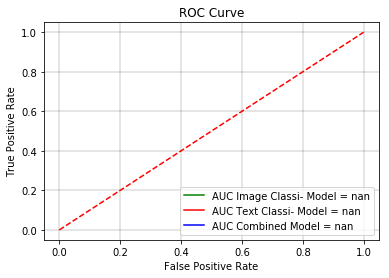

In [106]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# lab = multi_label_one_hat.astype(int)
predictions_prob = probs
# print (type(lab),type(predictions_prob),lab)
# auc1 = roc_auc_score(lab, predictions_prob[:,0].reshape(-1.1))
# auc2 = roc_auc_score(lab, predictions_prob[:,1].reshape(-1.1))
# auc3 = roc_auc_score(lab, predictions_prob[:,2].reshape(-1.1))
false_positive_rate, recall, thresholds   = roc_curve(l, predictions_prob[:,0].reshape(-1,1),l)
false_positive_rate2, recall2, thresholds = roc_curve(l, predictions_prob[:,1].reshape(-1,1),l)
false_positive_rate3, recall3, thresholds = roc_curve(l, predictions_prob[:,2].reshape(-1,1),l)
roc_auc = auc(false_positive_rate, recall)
fig=plt.plot(false_positive_rate, recall, 'g', label = 'AUC %s = %0.2f' % ('Image Classi- Model', roc_auc))
plt.plot(false_positive_rate2, recall2, 'r', label = 'AUC %s = %0.2f' % ('Text Classi- Model', auc(false_positive_rate2, recall2)))
plt.plot(false_positive_rate3, recall3, 'b', label = 'AUC %s = %0.2f' % ('Combined Model', auc(false_positive_rate3, recall3)))
plt.plot([0,1], [0,1], 'r--')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
ax = plt.axes()
ax.grid(color='k',linestyle='-', linewidth=0.2)
ax.set_facecolor('white')
print(plt.axes())

tprs = np.array(recall)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.fill_between(false_positive_rate, recall -0.05 ,np.minimum(1,recall + 0.05), color='grey', alpha=0.3)

plt.fill_between(false_positive_rate2, recall2 -0.04 ,np.minimum(1,recall2 + 0.04), color='green', alpha=0.3)
# plt.fill_between(false_positive_rate3, recall3 -0.04 ,np.minimum(1,recall3 + 0.04), color='blue', alpha=0.3)
# plt.set